<a href="https://colab.research.google.com/github/zoetice/data-science/blob/main/Zoe_TiceU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)



In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi

In [ ]:
import bambi as bmb

# **DATA Set:**

In [ ]:
cruise = pd.read_csv(
    'https://raw.githubusercontent.com/zoetice/data-science/refs/heads/main/cruise%20sheet%20-%20Sheet1.csv'
    ).dropna()

In [ ]:
cruise

,Name,Line,Age,Tonnage (x1000),Passengers (x100),Length (ft) (x100),Cabins (x100),Crew (x100)
0,Journey,Azamara,6,30.277,6.49,5.94,3.55,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,10.00
...,...,...,...,...,...,...,...,...
153,Taurus,Star,22,3.341,0.66,2.79,0.33,0.59
154,Virgo,Star,14,76.800,19.60,8.79,9.67,12.00
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,0.88
156,Star,Windstar,27,5.350,1.67,4.40,0.74,0.88


# Possible Predictors:
I jotted down some possible predictors to help find the amount of people in the crew on a given ship


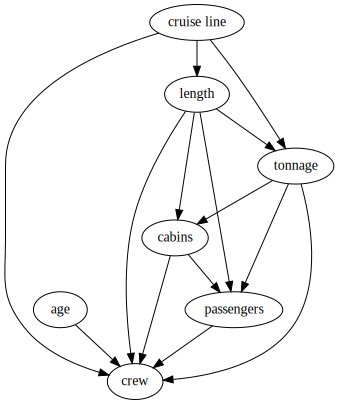

In [ ]:
dag_c = gv.Digraph(comment='cruise')

dag_c.node('L', 'cruise line')
dag_c.node('A','age')
dag_c.node('T','tonnage')
dag_c.node('P','passengers')
dag_c.node('E','length')
dag_c.node('C','cabins')
dag_c.node('R','crew')

dag_c.edges(['LR','AR','LT','TP','TC','TR','PR','ET', 'EP','EC','ER','CP','CR','LE'])

dag_c

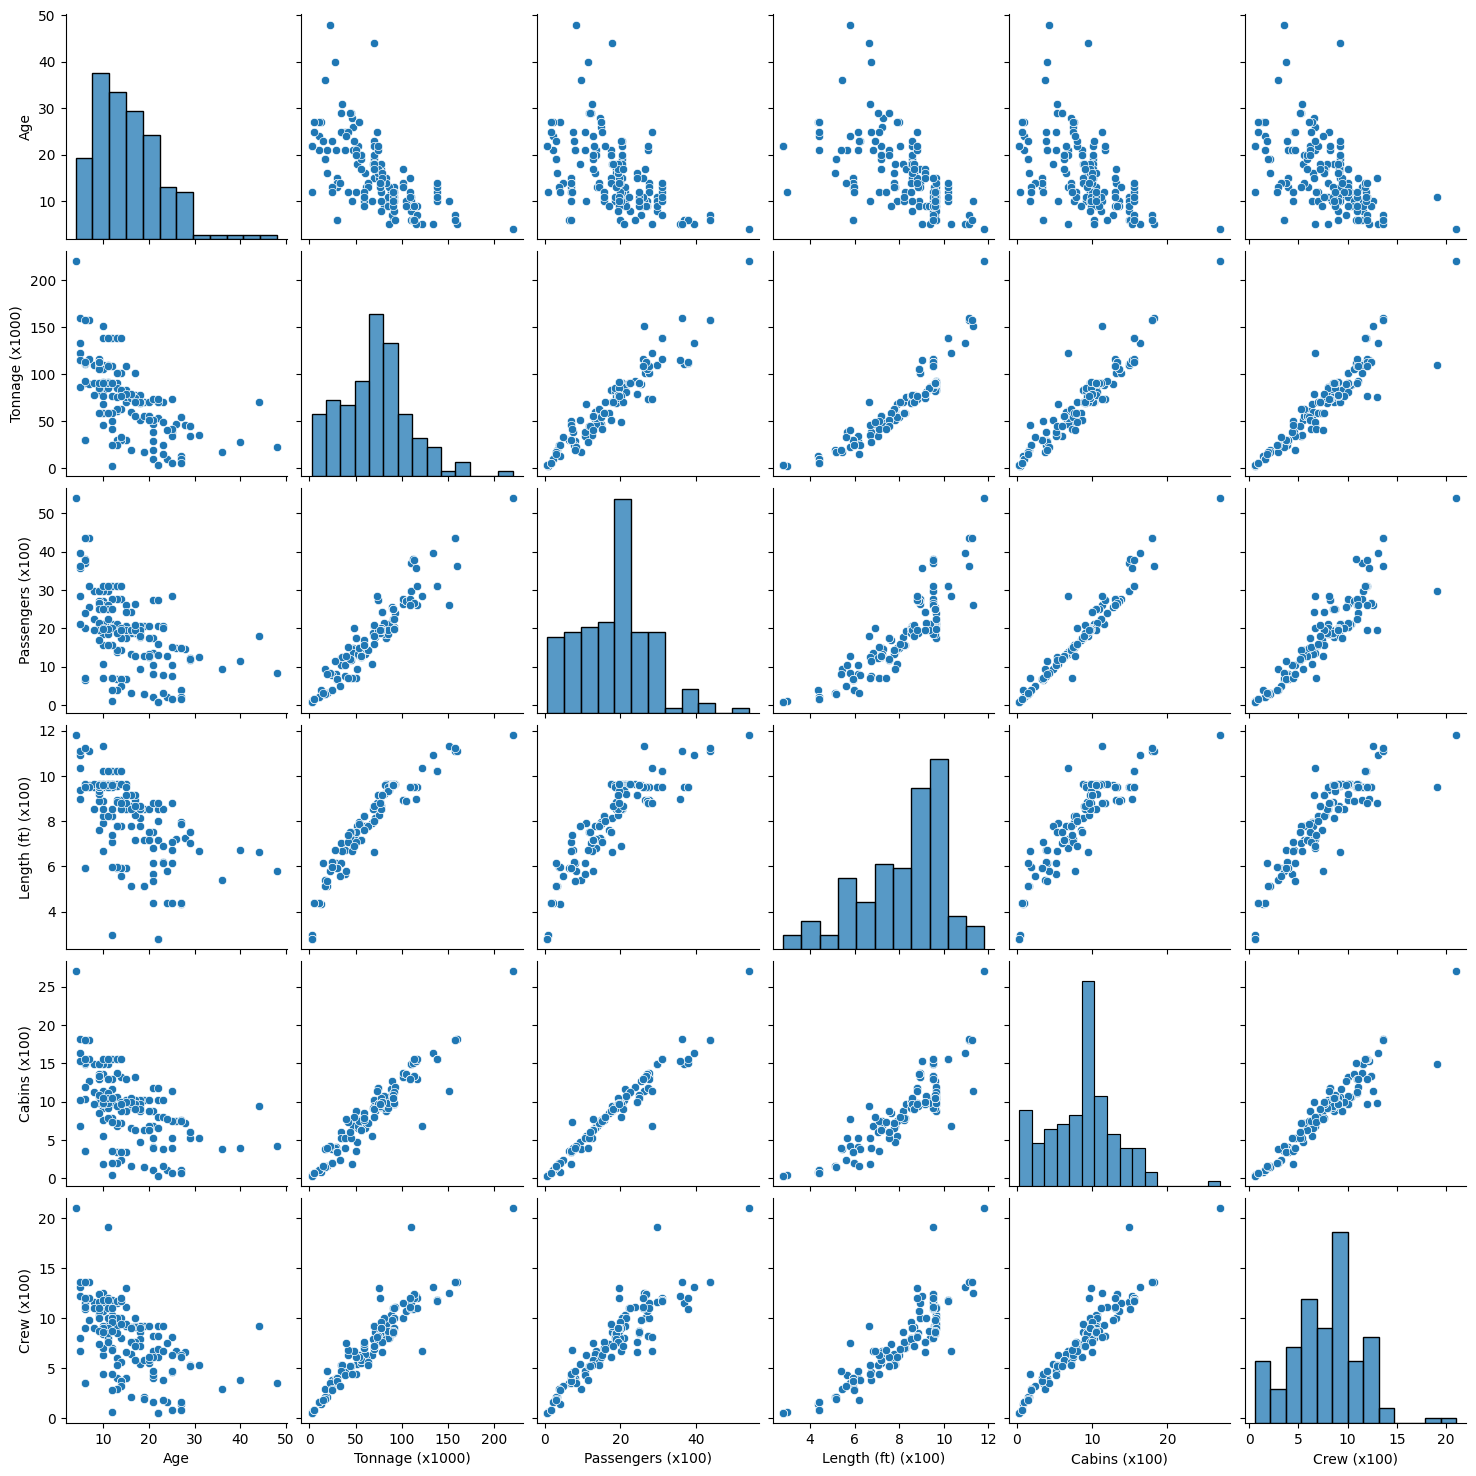

In [ ]:
sns.pairplot(cruise)

# Models:
Now I will make several models, with the different predictors doing different things and see which one works the best

In [ ]:
cruise_cleaned = cruise.rename(columns={
    'Tonnage (x1000)': 'Tonnage',
    'Passengers (x100)': 'Passengers',
    'Length (ft) (x100)': 'Length',
    'Cabins (x100)': 'Cabins',
    'Crew (x100)': 'Crew'
})

model_1 = bmb.Model("Crew ~ Tonnage + Passengers", cruise_cleaned)
idata_1 = model_1.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_2 = bmb.Model("Crew ~ Tonnage + (1|Passengers)", cruise_cleaned)
idata_2 = model_2.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
model_3 = bmb.Model("Crew ~ Tonnage * Passengers", cruise_cleaned)
idata_3 = model_3.fit(idata_kwargs={"log_likelihood":True}, tune=2000, draws=2000, target_accept=0.99)

In [ ]:
model_4 = bmb.Model("Crew ~ Tonnage * Passengers * Cabins", cruise_cleaned)
idata_4 = model_4.fit(idata_kwargs={"log_likelihood":True}, tune=2000, draws=2000, target_accept=0.99)

In [ ]:
model_5 = bmb.Model("Crew ~ Tonnage + Passengers + Cabins + (Tonnage * Passengers * Cabins)", cruise_cleaned)
idata_5 = model_5.fit(idata_kwargs={"log_likelihood":True}, tune=2000, draws=2000, target_accept=0.99)

In [ ]:
model_6 = bmb.Model("Crew ~ Tonnage + Passengers + `Cabins` + `Cabins`:Passengers", cruise_cleaned)
idata_6 = model_6.fit(idata_kwargs={"log_likelihood":True}, tune=2000, draws=2000, target_accept=0.99)

In [ ]:
model_7 = bmb.Model("Crew ~ Tonnage + Passengers + Cabins", cruise_cleaned)
idata_7 = model_7.fit(idata_kwargs={"log_likelihood":True}, tune=2000, draws=2000, target_accept=0.99)

In [ ]:
models_dict = {
    "Model 1: Tonnage + Passengers": idata_1,
    "Model 2: Tonnage + (1|Passengers)": idata_2,
    "Model 3: Tonnage * Passengers": idata_3,
    "Model 4: Tonnage * Passengers * Cabins": idata_4,
    "Model 5: Tonnage + Passengers + Cabins + (Tonnage * Passengers * Cabins)": idata_5,
    "Model 6: Tonnage + Passengers + `Cabins` + `Cabins`:Passengers": idata_6,
    "Model 7: Tonnage + Passengers + Cabins": idata_7
}

comp_df = az.compare(models_dict)
print(comp_df)

az.plot_compare(comp_df, insample_dev=False)
plt.show()

"Tonnage * Passengers * Cabins", "Tonnage + Passengers + Cabins + Cabins:Passengers", "Tonnage + Passengers + Cabins + (Tonnage * Passengers * Cabins)", and "Tonnage + Passengers + Cabins" all look good. I've chosen to use "Tonnage + Passengers + Cabins" as is includes all three predictors but keeps things simple with no interactions.

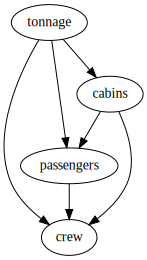

In [ ]:
dag_c2 = gv.Digraph(comment='cruise')

dag_c2.node('T','tonnage')
dag_c2.node('P','passengers')
dag_c2.node('R','crew')
dag_c2.node('C','cabins')

dag_c2.edges(['TR','TP','PR','CR','CP','TC'])

dag_c2

# Visualizing the model(s)

In [ ]:
model_cruise2_bmb = bmb.Model("Crew ~ Tonnage + Passengers + `Cabins` + `Cabins`:Passengers", cruise_cleaned, family="negativebinomial")
idata_cruise2_bmb = model_cruise2_bmb.fit(idata_kwargs={"log_likelihood":True})

In [ ]:
bmb.interpret.plot_predictions(model_cruise2_bmb, idata_cruise2_bmb, ["Tonnage", "Passengers"],
                               #subplot_kwargs={"group":None, "panel":"Passengers"},
                               legend=True,
                               fig_kwargs={"sharey":True, "sharex":True}, pps=True)

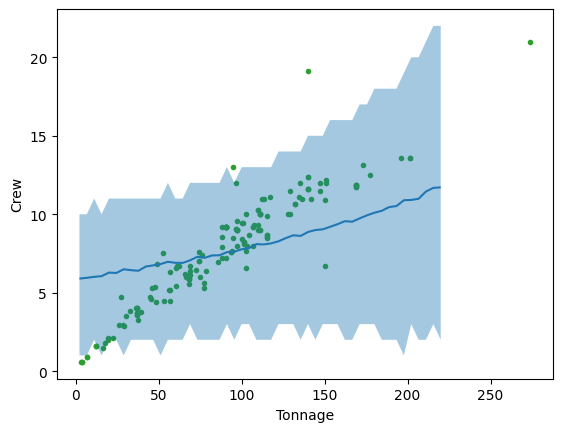

In [ ]:
bmb.interpret.plot_predictions(model_cruise2_bmb, idata_cruise2_bmb, "Tonnage", pps = True)
plt.plot(cruise_cleaned.Tonnage + cruise_cleaned.Passengers, cruise_cleaned.Crew, "C2.", zorder=-3)

In [ ]:
model_cruise_bmb = bmb.Model("Crew ~ Tonnage + Passengers + Cabins", cruise_cleaned, family="negativebinomial")
idata_cruise_bmb = model_cruise_bmb.fit(idata_kwargs={"log_likelihood":True})

(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='Tonnage', ylabel='Crew'>], dtype=object))

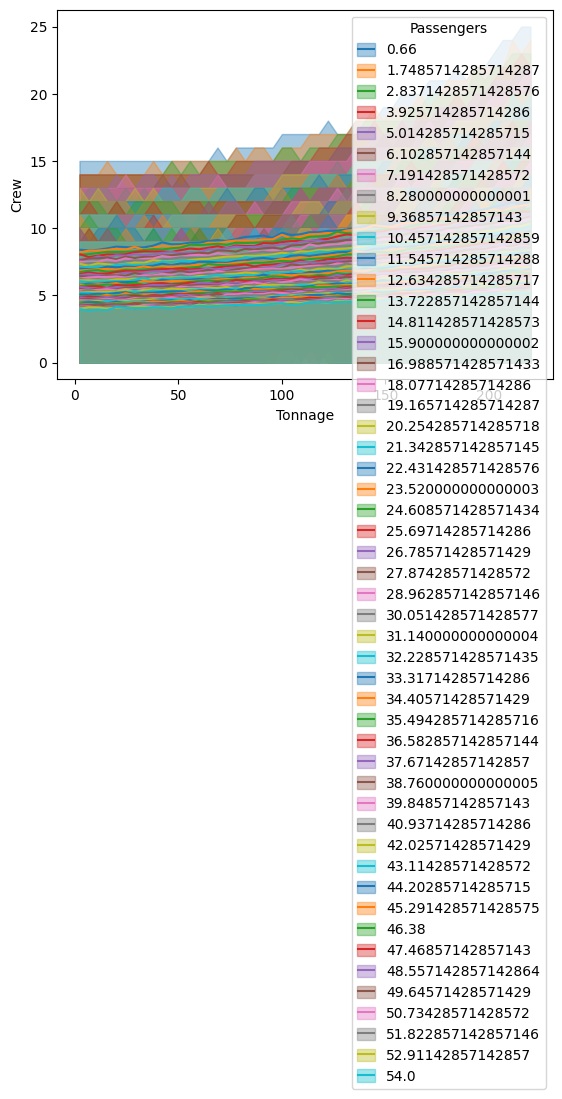

In [ ]:
bmb.interpret.plot_predictions(model_cruise_bmb, idata_cruise_bmb, ["Tonnage", "Passengers"],
                               #subplot_kwargs={"group":None, "panel":"Passengers"},
                               legend=True,
                               fig_kwargs={"sharey":True, "sharex":True}, pps=True)

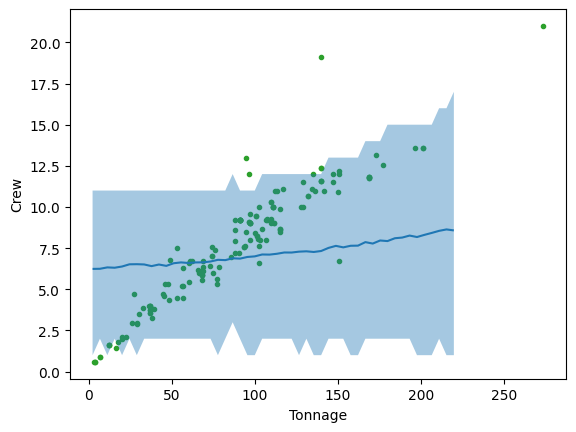

In [ ]:
bmb.interpret.plot_predictions(model_cruise_bmb, idata_cruise_bmb, "Tonnage", pps = True)
plt.plot(cruise_cleaned.Tonnage + cruise_cleaned.Passengers, cruise_cleaned.Crew, "C2.", zorder=-3)

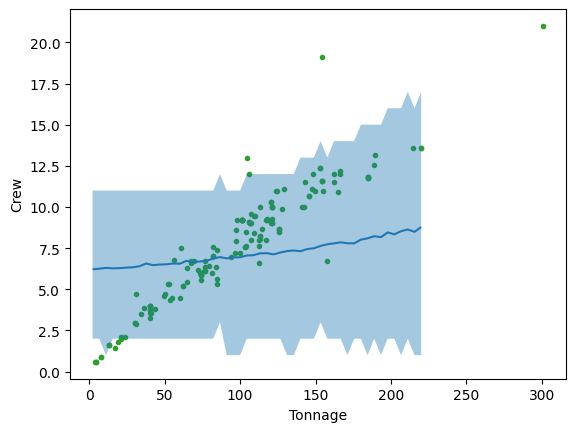

In [ ]:
bmb.interpret.plot_predictions(model_cruise_bmb, idata_cruise_bmb, "Tonnage", pps = True)
plt.plot(cruise_cleaned.Tonnage + cruise_cleaned.Passengers + cruise_cleaned.Cabins, cruise_cleaned.Crew, "C2.", zorder=-3)

# Analysis:
**What did not make sense:** The Rainbow graph showed that as the Tonnage went up, so did the Crew numbers, but as the Passengers went up with the Tonnage, the crew went down, which didn't make much sense to me, and goes against the pairplot.

**What did make sense:** using more predictors (3 in this case) gave a more accurate reading and prediction, and using a simpler model worked just as well if not better in this case.

**What does this mean in real life?** Cruises will have bigger crews if the boat itself is bigger, and if there are more people to serve on the cruise. *Makes sense...*